<a href="https://colab.research.google.com/github/aarmentamna/machine_learning_advance/blob/main/TC5033_Activity3b_42.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## **Maestría en Inteligencia Artificial Aplicada**
### **Curso: ADVANCED MACHINE LEARNING METHODS**
## Tecnológico de Monterrey
### Dr. José Antonio Cantoral Ceballos

## Activity Week 7
### Text Classification using RNNs and AG_NEWS dataset in PyTorch

*TEAM MEMBERS:*

*   Roberto Romero Vielma - A00822314
*   José Javier Granados Hernández - A00556717
*   Aquiles Yonatan Armenta Hernandez - A01793252
*   Alan Avelino Fernández Juárez - A00989308

## TC 5033
### Word Embeddings

<br>

#### Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested.

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%):
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy function (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


### Import libraries
1. `import numpy as np`: The 'numpy' library is imported and aliased as 'np' for numerical operations.

2. `import torch`: The PyTorch library is imported for deep learning tasks.

3. `from torchtext.datasets import AG_NEWS`: The 'AG_NEWS' dataset is imported from the 'torchtext.datasets' module.

4. `from torch.utils.data import DataLoader`: The 'DataLoader' class is imported from the 'torch.utils.data' module.

5. `from torch.utils.data.dataset import random_split`: The 'random_split' function is imported from the 'torch.utils.data.dataset' module.

6. `from torchtext.data.utils import get_tokenizer`: The 'get_tokenizer' function is imported from 'torchtext.data.utils'.

7. `from torchtext.vocab import build_vocab_from_iterator`: The 'build_vocab_from_iterator' function is imported from 'torchtext.vocab'.

8. `from torchtext.data.functional import to_map_style_dataset`: The 'to_map_style_dataset' function is imported from 'torchtext.data.functional'.

9. `from torch import nn`: The 'nn' module from PyTorch is imported for building neural network layers.

10. `from torch.nn import functional as F`: The 'F' module from 'torch.nn' is imported for functional operations in neural networks.

11. `import scikitplot as skplt`: The 'scikitplot' library is imported and aliased as 'skplt.' This library is suggested for plotting confusion matrices.

12. `import gc`: The 'gc' (garbage collector) module is imported for memory management and cleanup.

The code prepares the environment by importing the required libraries, making them available for further tasks such as data preprocessing, model building, and evaluation, including the plotting of confusion matrices using 'scikitplot.'

In [2]:
# Install the 'scikit-plot' library using pip.
!pip install scikit-plot

# Install 'portalocker' library with a minimum version requirement of 2.0.0 using pip.
!pip install portalocker>=2.0.0

In [3]:
import numpy as np # Import the 'numpy' library and alias it as 'np' for numerical operations.

# PyTorch libraries
import torch # Import the PyTorch library for deep learning tasks.
from torchtext.datasets import AG_NEWS # Import the 'AG_NEWS' dataset from the 'torchtext.datasets' module.

# Dataloader library
from torch.utils.data import DataLoader # Import the 'DataLoader' class from the 'torch.utils.data' module.
from torch.utils.data.dataset import random_split # Import the 'random_split' function from the 'torch.utils.data.dataset' module.

# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer # Import the 'get_tokenizer' function from 'torchtext.data.utils'.
from torchtext.vocab import build_vocab_from_iterator # Import 'build_vocab_from_iterator' function from 'torchtext.vocab'.
from torchtext.data.functional import to_map_style_dataset # Import the 'to_map_style_dataset' function from 'torchtext.data.functional'.


# Neural Layers
from torch import nn # Import the 'nn' module from PyTorch for building neural network layers.
from torch.nn import functional as F # Import the 'F' module from 'torch.nn' for functional operations in neural networks.

# Plot a confusion matrix
import scikitplot as skplt # Import the 'scikitplot' library and alias it as 'skplt' for confusion matrix plotting.

import gc # Import the 'gc' (garbage collector) module for memory management and cleanup.


In [38]:
# Check if a CUDA-compatible GPU is available; if yes, use CUDA, otherwise, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the selected device (CUDA or CPU)
print(device)

cuda


### Get the train and the test datasets and dataloaders
The following code demonstrates various steps in data preprocessing and dataset splitting for a machine learning or deep learning task.

#### Data Loading and Dataset Splitting

1. **Load the AG_NEWS dataset and Split:** Initially, the AG_NEWS dataset is loaded and then split into two datasets: `train_dataset` and `test_dataset`.

2. **Convert to Map-Style Datasets:** Both the training and testing datasets are converted to map-style datasets using the `to_map_style_dataset` function. Map-style datasets are a common format for data processing in PyTorch.

#### Tokenization and Vocabulary Building

3. **Tokenization Setup:** A tokenizer is defined using the 'basic_english' configuration, which is suitable for processing English text.

4. **Token Yielding Function:** A function named `yield_tokens` is defined to extract tokens from the given data. It iterates through the data and tokenizes the text using the `tokeniser`.

5. **Vocabulary Building:** A vocabulary is built from the tokens yielded by the `yield_tokens` function, with the special token "<unk>" used to represent unknown words. The vocabulary is created using the `build_vocab_from_iterator` function.

6. **Default Index Set:** The default index of the vocabulary is set to "<unk>" to handle out-of-vocabulary words. If a token is not found in the vocabulary, it defaults to "<unk>."

#### Tokenization and Data Splitting

7. **Tokenization of Input Text:** The input text, "Welcome to TE3007," is tokenized using the 'tokeniser.'

8. **Validation Dataset Size Calculation:** The code calculates the number of samples for the training and validation datasets. It reserves 90% of the data for training and assigns the remaining for validation.

9. **Training and Validation Split:** The training dataset is split into two sets, `train_dataset` (containing `NUM_TRAIN` samples for training) and `val_dataset` (containing `NUM_VAL` samples for validation).

#### Dataset Lengths

10. **Dataset Lengths:** Finally, the lengths of the training, validation, and test datasets are printed to provide insights into the size of each dataset. This information is crucial for data preparation and model training.

This code demonstrates essential steps in data preprocessing, including tokenization, vocabulary building, and dataset splitting, to prepare the data for subsequent deep learning tasks.

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [39]:
# Load the AG_NEWS dataset and split it into training and testing datasets
train_dataset, test_dataset = AG_NEWS()
# Convert the datasets to map-style datasets
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [40]:
# Define a tokenizer using the 'basic_english' configuration
tokeniser = get_tokenizer('basic_english')

# Define a function to yield tokens from the given data
def yield_tokens(data):
    for _, text in data:
        # Tokenize the text using the previously defined 'tokeniser'
        yield tokeniser(text)

In [41]:
# Build a vocabulary from the tokens yielded by the 'yield_tokens' function on the training dataset
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
# The 'specials' argument specifies special tokens, and "<unk>" is used for unknown words.

# Set the default index of the vocabulary to "<unk>" (unknown) token
vocab.set_default_index(vocab["<unk>"])
# This ensures that if a token is not found in the vocabulary, it defaults to "<unk>" for handling out-of-vocabulary words.

In [43]:
# Tokenize the input text using the 'tokeniser'
tokens = tokeniser('Welcome to TE3007')
# Print the original tokens and their corresponding indices
print(tokens, vocab(tokens))

['welcome', 'to', 'te3007'] [3314, 4, 0]


In [44]:
# Calculate the number of samples for the training dataset by taking 90% of the entire dataset.
NUM_TRAIN = int(len(train_dataset) * 0.9)

# Calculate the number of samples for the validation dataset by subtracting the training dataset size from the total dataset size.
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [45]:
# Split the training dataset into training and validation datasets
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

# 'train_dataset' now contains NUM_TRAIN samples for training.
# 'val_dataset' now contains NUM_VAL samples for validation.

In [46]:
# Print the lengths of the training, validation, and test datasets
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


### Batch Collation Function

1. **Splitting Labels and Text Data:** The function starts by receiving a batch of data. It separates the labels (y) and text data (x) using the `list(zip(*batch))` operation.

2. **Tokenization and Numerical Conversion:** It then tokenizes the text data using a previously defined tokenizer (`tokeniser`) and converts the tokens to numerical representations using a vocabulary (`vocab`).

3. **Padding and Truncation:** To ensure that all sequences have the same length for efficient processing, the function checks the length of each sequence. If a sequence is shorter than a predefined maximum length (`max_tokens`), it is padded with zeros to match the maximum length. If it's longer, it's truncated to the maximum length.

4. **Data Type Conversion:** Finally, the function converts the processed data into PyTorch tensors. The text data is represented as a tensor with data type `torch.int32`, and the labels are adjusted by subtracting 1 from them and represented as tensors with the same data type.

In [47]:
# Define a function for batch collation
def collate_batch(batch):
    # Split the batch into labels (y) and text data (x)
    y, x = list(zip(*batch))

    # Tokenize the text data and convert to numerical representations using the vocabulary
    x = [vocab(tokeniser(text)) for text in x]

    # Pad or truncate sequences to a maximum length (max_tokens)
    x = [t + ([0] * (max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Convert the tokenized and padded/truncated sequences to PyTorch tensors
    return torch.tensor(x, dtype=torch.int32), torch.tensor(y, dtype=torch.int32) - 1

In [48]:
# Define a list of labels for the AG_NEWS dataset
labels = ["World", "Sports", "Business", "Sci/Tech"]

# Define the maximum number of tokens allowed in a sequence
max_tokens = 50

# Define the batch size for training and data processing
BATCH_SIZE = 256

In [49]:
# Create a DataLoader for the training dataset with a specified batch size and data processing function
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=True)

# Create a DataLoader for the validation dataset with the same batch size and processing function
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=True)

# Create a DataLoader for the test dataset with the same batch size and processing function
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=True)

### Let us build our RNN model
The following code defines a custom recurrent neural network (RNN) model class named `RNN_Model_1` for sequence classification tasks.

#### Model Architecture

1. **Initialization:** In the constructor (`__init__`), the model is initialized with the following parameters:
    - `embed_size`: The size of the word embedding vectors.
    - `hidden`: The number of hidden units in the RNN layer.
    - `layers`: The number of stacked RNN layers.
    - `num_classes`: The number of classes in the classification task.

2. **Embedding Layer:** An embedding layer is created using the `nn.Embedding` module. This layer converts input tokens to dense vectors. The `num_embeddings` parameter is set to the length of the vocabulary (`len(vocab)`) to match the vocabulary size, and the `embedding_dim` is set to the specified `embed_size`.

3. **RNN (GRU) Layer:** An RNN layer, specifically a Gated Recurrent Unit (GRU) layer, is created using `nn.GRU`. It takes the embedded input and processes it through recurrent layers. The `input_size` is set to `embed_size`, the `hidden_size` to `hidden`, the `num_layers` to `layers`, and `batch_first` is set to `True`.

4. **Fully Connected Layer:** A fully connected layer is created using `nn.Linear`. It is used for the final classification. The `input_size` is `hidden`, and the `output_size` is `num_classes`.

### Forward Pass

The `forward` method specifies how data is passed through the model:
1. The input `x` is first cast to `torch.int64` to ensure the correct data type.
2. The input sequence is embedded using the previously defined embedding layer.
3. The embedded sequence is passed through the GRU layer to capture sequential information.
4. The output from the RNN layer is extracted from the last time step.
5. Finally, the output is passed through the fully connected layer for classification.

This model architecture is designed for sequence classification tasks, such as text classification, where the input sequence is processed to make class predictions.


In [51]:
# Define the embedding size for word embeddings in the model
EMBEDDING_SIZE = 100

# Define the number of neurons in each hidden layer of the neural network
NEURONS = 64

# Define the number of layers in the neural network
LAYERS = 2

# Define the number of classes in the classification task
NUM_CLASSES = len(labels)

In [52]:
# Define a custom RNN model class (RNN_Model_1)
class RNN_Model_1(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super().__init__()

        # Create an embedding layer for converting input tokens to dense vectors
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab),
                                            embedding_dim=embed_size)
        # 'vocab' should be defined previously and represents the vocabulary for the dataset.

        # Create an RNN (GRU) layer for sequence processing
        self.rnn = nn.GRU(input_size=embed_size, hidden_size=hidden, num_layers=layers, batch_first=True)

        # Create a fully connected layer for classification
        self.fc = nn.Linear(hidden, num_classes)

    def forward(self, x):
        x = x.to(torch.int64)  # Ensure the input is of type 'torch.int64'

        # Embed the input sequence
        embedded = self.embedding_layer(x)

        # Pass the embedded sequence through the RNN layer
        output, _ = self.rnn(embedded)

        # Extract the output at the last time step of the sequence
        output = output[:, -1, :]

        # Pass the output through the fully connected layer for classification
        output = self.fc(output)

        return output

### Accuracy

The code below defines a function named `accuracy` for calculating the accuracy of a given model on a specified data loader. The function returns the accuracy as a floating-point value.

#### Accuracy Calculation

1. **Initialization:** Inside the `accuracy` function, two variables are initialized:
   - `num_correct`: A counter for the number of correctly predicted instances.
   - `num_total`: A counter for the total number of instances.

2. **Model Evaluation:** The model is set to evaluation mode using `model.eval()`. This is important for ensuring that layers like dropout and batch normalization behave differently during evaluation compared to training.

3. **Device Configuration:** The model is moved to the specified device (e.g., GPU or CPU) using `model.to(device=device)` to ensure that calculations are performed on the selected device.

4. **Accuracy Computation:** The function iterates through the data loader. For each batch of data:
   - The input (`x`) and target labels (`y`) are moved to the same device as the model with appropriate data types.
   - The model is used to predict scores for the input data (`scores`).
   - The predictions with the highest scores are obtained using `scores.max(dim=1)`.
   - Correct predictions are counted by comparing the predictions to the true labels (`y`), and the number of correct predictions is added to `num_correct`.
   - The total number of instances in the batch is added to `num_total`.

5. **Accuracy Calculation:** The final accuracy is computed by dividing the number of correct predictions (`num_correct`) by the total number of instances (`num_total`). The result is returned as a floating-point value.


In [53]:
# Define a function for calculating the accuracy of a given model on a specified data loader
def accuracy(model, loader):
    num_correct = 0  # Initialize a counter for the number of correctly predicted instances
    num_total = 0  # Initialize a counter for the total number of instances

    model.eval()  # Set the model to evaluation mode
    model = model.to(device=device)  # Move the model to the specified device

    with torch.no_grad():  # Disable gradient tracking during inference
        for x, y in loader:  # Iterate through the data loader
            x = x.to(device=device, dtype=torch.float32)  # Move input data to the device with the appropriate data type
            y = y.to(device=device, dtype=torch.long)  # Move target labels to the device with the appropriate data type
            scores = model(x)  # Use the model to predict scores for the input data
            _, predictions = scores.max(dim=1)  # Find the class with the highest score for each instance
            num_correct += (predictions == y).sum()  # Count the number of correct predictions in the batch
            num_total += predictions.size(0)  # Add the total number of instances in the batch to the counter

    return float(num_correct / num_total)  # Compute and return the accuracy as a floating-point value

### Training

The following code defines a training function for deep learning model. This function is responsible for training the model over multiple epochs using the specified data loader and optimizing the model's parameters using an optimizer.

### Function Overview

The `train` function has the following components:

1. **Model and Device Configuration:**
   - The function starts by moving the model to the specified device (CPU or GPU) using `model.to(device=device)`. This ensures that all computations occur on the selected hardware.
   
2. **Epochs Loop:**
   - The training process is executed for a specified number of training epochs. The outer loop iterates over each epoch using `for epoch in range(epochs)`.

3. **Data Loading:**
   - Within each epoch, the inner loop iterates over the training data using `for i, (x, y) in enumerate(train_loader)`. This loop allows the model to process the entire training dataset in batches.

4. **Training Mode:**
   - The model is set in training mode with `model.train()`. This is necessary to enable gradient computation and backpropagation during training.

5. **Data Preparation:**
   - Input data (`x`) is moved to the specified device with the appropriate data type (`dtype=torch.float32`), and target labels (`y`) are also moved to the device with the appropriate data type (`dtype=torch.long`).

6. **Forward Pass and Loss Computation:**
   - The model is used to predict scores for the input data (`scores`).
   - The cross-entropy loss is computed using `F.cross_entropy`. This loss quantifies the error between predicted scores and true labels.

7. **Gradient Computation:**
   - The gradients are cleared to prevent gradient accumulation with `optimiser.zero_grad()`.
   - Backpropagation is performed using `cost.backward()` to compute gradients.

8. **Parameter Update:**
   - The model's parameters are updated using the optimizer (`optimiser`) with `optimiser.step()`.

9. **Validation and Logging:**
   - After each epoch, the accuracy of the model on the validation set is calculated using the `accuracy` function.
   - Training statistics such as the current epoch, cost (loss), and accuracy are printed to monitor the training progress using `print(f'Epoch: {epoch}, cost: {cost.item()}, accuracy: {acc}.')`.

This `train` function is a fundamental component for training machine learning models. It encapsulates the process of forward and backward passes, parameter updates, and performance monitoring over multiple training epochs.


In [59]:
# Define a training function for a machine learning model.
def train(model, optimizer, epochs=100):
    model = model.to(device=device)  # Move the model to the specified device (CPU or GPU).

    for epoch in range(epochs):  # Iterate over the specified number of training epochs.
        for i, (x, y) in enumerate(train_loader):  # Loop through the training data.
            model.train()  # Set the model in training mode to enable gradient computation.
            x = x.to(device=device, dtype=torch.float32)  # Move input data to the specified device with the appropriate data type.
            y = y.to(device=device, dtype=torch.long)  # Move target labels to the specified device with the appropriate data type.
            scores = model(x)  # Get the model's predicted scores.
            cost = F.cross_entropy(input=scores, target=y)  # Calculate the cross-entropy loss.
            optimizer.zero_grad()  # Zero the gradients to prevent gradient accumulation.
            cost.backward()  # Perform backpropagation to compute gradients.
            optimizer.step()  # Update model parameters using the optimizer.

        acc = accuracy(model, val_loader)  # Calculate the accuracy of the model on the validation set.
        print(f'Epoch: {epoch+1}/{epochs}, Loss: {cost.item()}, Validation Accuracy: {acc}') # Print training statistics including the current epoch, loss, and accuracy on the validation set.

In [60]:
# Set the number of training epochs to 20 for model training.
epochs = 20

# Set the learning rate (lr) to 0.001 for the Adam optimizer.
lr = 0.001

# Create an instance of the RNN model (RNN_Model_1) with specified parameters.
rnn_model = RNN_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES)

# Initialize the optimizer (Adam) for updating the model's parameters with the specified learning rate (lr).
optimiser = torch.optim.Adam(rnn_model.parameters(), lr=lr)

In [61]:
# Train the RNN model using the provided optimizer and the specified number of training epochs.
train(rnn_model, optimiser, epochs)

Epoch: 1/20, Loss: 0.4078494906425476, Validation Accuracy: 0.8672499656677246
Epoch: 2/20, Loss: 0.30579081177711487, Validation Accuracy: 0.89083331823349
Epoch: 3/20, Loss: 0.23732435703277588, Validation Accuracy: 0.8993332982063293
Epoch: 4/20, Loss: 0.24835409224033356, Validation Accuracy: 0.9035833477973938
Epoch: 5/20, Loss: 0.1812761276960373, Validation Accuracy: 0.90666663646698
Epoch: 6/20, Loss: 0.06027740612626076, Validation Accuracy: 0.9047499895095825
Epoch: 7/20, Loss: 0.07101806998252869, Validation Accuracy: 0.9024999737739563
Epoch: 8/20, Loss: 0.11584451049566269, Validation Accuracy: 0.9026666283607483
Epoch: 9/20, Loss: 0.03700289875268936, Validation Accuracy: 0.8968333005905151
Epoch: 10/20, Loss: 0.047504816204309464, Validation Accuracy: 0.8996666669845581
Epoch: 11/20, Loss: 0.04771220684051514, Validation Accuracy: 0.8970833420753479
Epoch: 12/20, Loss: 0.025246618315577507, Validation Accuracy: 0.8983333110809326
Epoch: 13/20, Loss: 0.02130107954144478, 

In [62]:
# Print and display the test accuracy of the trained RNN model on the test dataset with four decimal places.
print(f'Test Accuracy: {accuracy(rnn_model, test_loader):.4f}')

Test Accuracy: 0.8950


### **Sample_text Function**

The `sample_text` function is designed to classify a sample text using a previously trained model. The following details its functionality:

#### Input Parameters:

- `model`: The pre-trained model to be used for classification.
- `loader`: The data loader that contains necessary information, such as vocabulary and device settings, for processing the sample text.
- `sample_text`: The text to be classified.

#### Flow of Operation:

1. **Evaluation Mode:** The function begins by setting the model to evaluation mode using `model.eval()`. This ensures that the model does not make parameter adjustments during classification.

2. **Tokenization:** The sample text is tokenized using the same tokenizer that was used during training. This ensures that the sample text is processed in the same way as the training data.

3. **Conversion to Tensor:** Tokens generated from the sample text are converted into a tensor and moved to the same device as the model using `torch.tensor([vocab(tokens)], dtype=torch.int64).to(device=device)`. This is necessary for the model to make predictions on the same device.

4. **Class Prediction:** The function uses the model to predict scores for the sample text. The scores represent the probability of belonging to each class. The class with the highest score (argmax) is sought to determine the predicted class.

5. **Output:** The function returns the index of the predicted class as the result, allowing the identification of the class to which the sample text is assigned.

In [70]:
def sample_text(model, loader, sample_text):
    model.eval()  # Set the model in evaluation mode.

    # Tokenize the sample text using the same tokenizer used for training.
    tokens = get_tokenizer('basic_english')(sample_text)

    # Convert tokens to a tensor and move it to the same device as the model.
    input_tensor = torch.tensor([vocab(tokens)], dtype=torch.int64).to(device=device)

    # Use the model to predict scores for the input text.
    with torch.no_grad():
        scores = model(input_tensor)

    # Find the class with the highest score (argmax) as the predicted class.
    _, predicted_class = scores.max(dim=1)

    return labels[predicted_class.item()]  # Return the predicted class index.

In [76]:
sample_text(rnn_model, test_loader, 'Mexico is located in North America') # Testing sample_text function

'World'

### Function to Create a Confusion Matrix for Classification

This function takes a trained PyTorch model and a data loader, evaluates the model on the data loader, and generates a confusion matrix using scikit-learn's `plot_confusion_matrix` function.

#### Function Steps

1. **Set Model to Evaluation Mode:**
   - `model.eval()`: Sets the model in evaluation mode to disable training-specific behavior. During evaluation, the model won't update its weights.

2. **Initialize Lists for True and Predicted Labels:**
   - `true_labels` and `predicted_labels` are empty lists that will store the true labels and predicted labels, respectively.

3. **Disable Gradient Computation:**
   - `with torch.no_grad()`: Disables gradient computation for this part of the code to save memory. We don't need gradients during evaluation.

4. **Iterate Over the Data Loader:**
   - Iterate over the data loader to get input data and their corresponding true labels.

5. **Move Data to Specified Device (e.g., GPU):**
   - `inputs, labels = inputs.to(device), labels.to(device)`: Moves the input data and true labels to the specified device, such as a GPU.

6. **Get Model Predictions:**
   - `output = model(inputs)`: Passes the input data through the model to get predictions. These predictions are represented as scores for each class.

7. **Find Predicted Classes:**
   - `_, predicted = torch.max(output, 1)`: Finds the class with the highest score for each input, determining the predicted class.

8. **Extend Lists with Batch Data:**
   - `true_labels.extend(labels.cpu().numpy())` and `predicted_labels.extend(predicted.cpu().numpy())`: Extend the `true_labels` and `predicted_labels` lists with the true labels and predicted labels from the current batch. Converting to NumPy arrays makes it easier to work with.

9. **Create the Confusion Matrix:**
   - `skplt.metrics.plot_confusion_matrix(true_labels, predicted_labels, figsize=(8, 6))`: Creates the confusion matrix using scikit-learn's `plot_confusion_matrix` function, visualizing the performance of the model.

In [77]:
def create_confusion_matrix(model, data_loader):
    # Set the model in evaluation mode to disable training-specific behavior
    model.eval()

    # Initialize empty lists to store true and predicted labels
    true_labels = []
    predicted_labels = []

    # Disable gradient computation for this part to save memory
    with torch.no_grad():
        # Iterate over the data loader to get inputs and labels
        for data in data_loader:
            inputs, labels = data

            # Move inputs and labels to the specified device (e.g., GPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Get model predictions for the inputs
            output = model(inputs)

            # Find the class with the highest score as the predicted class
            _, predicted = torch.max(output, 1)

            # Extend the true_labels and predicted_labels lists with data from the current batch
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # Create the confusion matrix using scikit-learn's plot_confusion_matrix
    cm = skplt.metrics.plot_confusion_matrix(true_labels, predicted_labels, figsize=(8, 6))

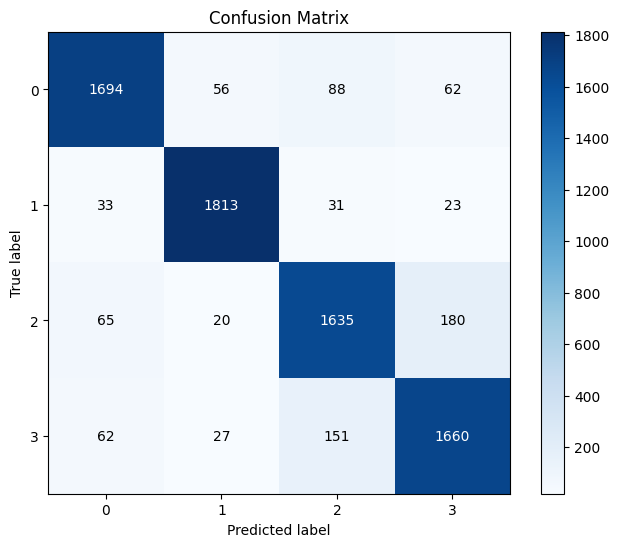

In [79]:
# Call the create_confusion_matrix function on your test_loader
confusion_matrix = create_confusion_matrix(rnn_model, test_loader)

### Most common mistakes made by the model
